In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import random; random.seed(20)

In [2]:
import plotly
plotly.tools.set_credentials_file(username=('your_username'), api_key=('your_api_key'))
import plotly.plotly as py
import plotly.graph_objs as go

In [3]:
wins = pd.read_csv(r'...\wins_df.csv')

In [4]:
wins.head()

,team,Year,game_num,num_wins_team,playoff_flag,wins_above_mean
0,BOS,1990,1,1,1,0.500000
1,BOS,1990,2,2,1,0.961538
2,BOS,1990,3,3,1,1.538462
3,BOS,1990,4,3,1,1.038462
4,BOS,1990,5,3,1,0.461538


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

roc_auc_scores = []

for game_number in range(1, 163):
    
    wins_game_num = wins[wins.game_num == game_number]
    
    x_train, x_test, y_train, y_test = train_test_split(wins_game_num[['num_wins_team']], wins_game_num[['playoff_flag']], 
                                                    test_size = 0.4, random_state = 15, 
                                                    stratify = wins_game_num['playoff_flag'])

    rf_classifier = RandomForestClassifier(n_estimators = 250)

    rf_classifier.fit(x_train, np.ravel(y_train))

    predictions = rf_classifier.predict(x_test)
    
    roc_auc_scores.append(roc_auc_score(y_test, predictions))

In [7]:
roc_curve_scores = pd.DataFrame()

for game_number in range(1, 163):
    
    wins_game_num = wins[wins.game_num == game_number]
    
    x_train, x_test, y_train, y_test = train_test_split(wins_game_num[['num_wins_team']], wins_game_num[['playoff_flag']], 
                                                    test_size = 0.4, random_state = 15, 
                                                    stratify = wins_game_num['playoff_flag'])

    rf_classifier = RandomForestClassifier(n_estimators = 250)

    rf_classifier.fit(x_train, np.ravel(y_train))

    predictions = rf_classifier.predict_proba(x_test)
    
    predictions = predictions[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    
    df = pd.DataFrame()
    df['fpr'] = fpr
    df['tpr'] = tpr
    df['roc_auc'] = roc_auc
    df['num_games'] = game_number
    
    roc_curve_scores = roc_curve_scores.append(df)

In [8]:
roc_curve_scores_mean = roc_curve_scores.reset_index()

In [9]:
roc_curve_scores_mean = roc_curve_scores_mean[roc_curve_scores_mean['index'] == 1]

In [10]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

rolling_10_game_mean = running_mean(list(roc_curve_scores_mean['roc_auc']), 10)

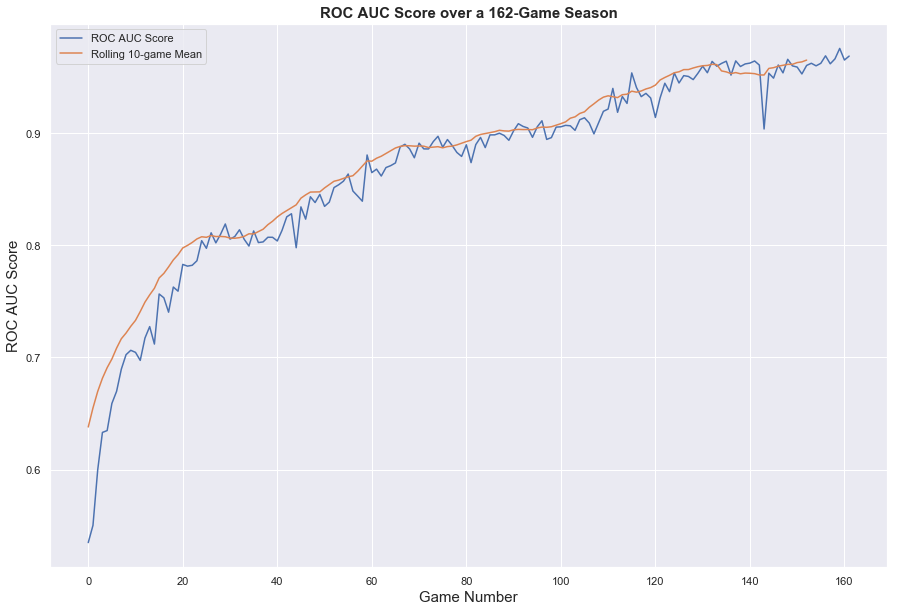

In [11]:
plt.figure(figsize = (15, 10))
plt.plot(list(roc_curve_scores['roc_auc'].drop_duplicates()), label = 'ROC AUC Score')
plt.plot(list(rolling_10_game_mean), label = 'Rolling 10-game Mean')
plt.xlabel('Game Number', fontsize = 15)
plt.ylabel('ROC AUC Score', fontsize = 15)
plt.title('ROC AUC Score over a 162-Game Season', fontsize = 15, fontweight = 'bold')
plt.legend()

plt.show()

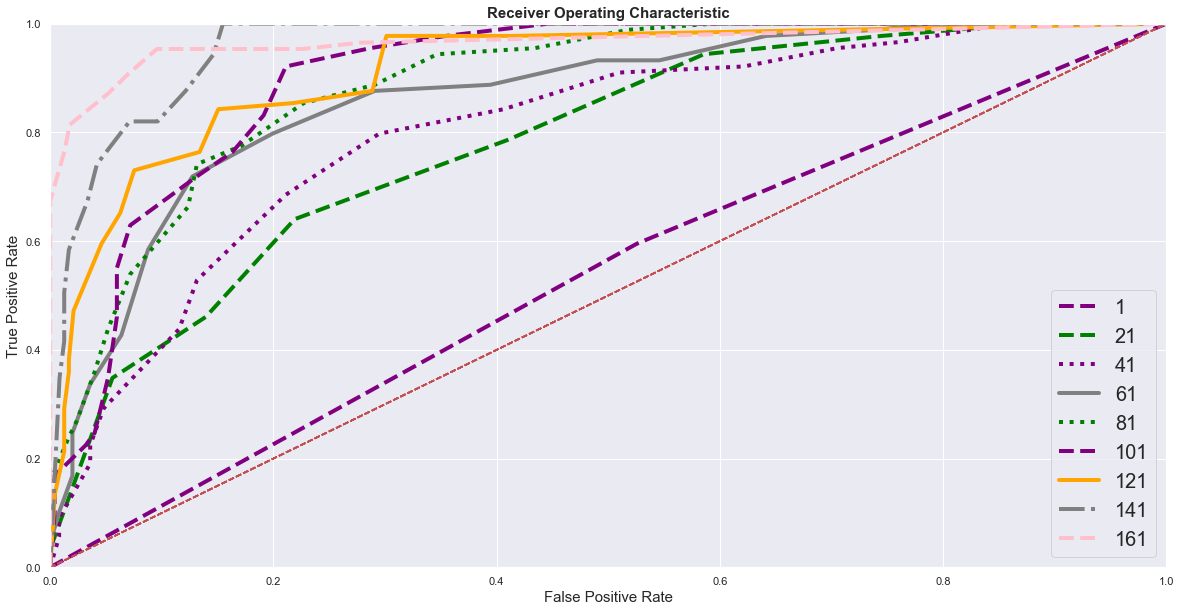

In [12]:
colors = ['blue','green','purple','pink','gold','black','gray','orange','brown']

plt.figure(figsize=(20,10))

for i in range(1, 163, 20):
    
    roc_curve_scores_i = roc_curve_scores[roc_curve_scores.num_games == i]
    
    plt.plot(roc_curve_scores_i['fpr'], roc_curve_scores_i['tpr'], 'b', color = colors[random.randint(0,8)],
            linestyle = random.choice([':','-.','--','-']), label = i, linewidth = 4)
    

    plt.title('Receiver Operating Characteristic', fontweight = 'bold', fontsize = 15)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.legend(prop = {'size' : 20}, loc = 'lower right')

plt.show()

# Random Model Simulation

In [13]:
random_curve_scores = pd.DataFrame()

num_runs = 0
desired_runs = 500

while num_runs <= desired_runs:
    
    for game_number in range(1, 163):
    
        wins_game_num = wins[wins.game_num == game_number]

        x_train, x_test, y_train, y_test = train_test_split(wins_game_num[['num_wins_team']], wins_game_num[['playoff_flag']], 
                                                        test_size = 0.4, random_state = random.randint(0, 100), 
                                                        stratify = wins_game_num['playoff_flag'])

        rf_classifier = RandomForestClassifier(n_estimators = random.randint(15,500), max_depth = random.randint(10,100), 
                                               max_features = random.choice(['auto','sqrt','log2', None]),
                                               min_samples_leaf = random.randint(1, 25))
                        

        rf_classifier.fit(x_train, np.ravel(y_train))

        predictions = rf_classifier.predict_proba(x_test)

        predictions = predictions[:,1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
        roc_auc = metrics.auc(fpr, tpr)

        df = pd.DataFrame()
        df['fpr'] = fpr
        df['tpr'] = tpr
        df['roc_auc'] = roc_auc
        df['num_games'] = game_number

        random_curve_scores = random_curve_scores.append(df)
        
        num_runs += 1

In [14]:
min_max_scores = pd.DataFrame()

min_max_scores['min'] = random_curve_scores[random_curve_scores.index == 1].groupby('num_games')['roc_auc'].min()
min_max_scores['max'] = random_curve_scores[random_curve_scores.index == 1].groupby('num_games')['roc_auc'].max()
min_max_scores['mean'] = random_curve_scores[random_curve_scores.index == 1].groupby('num_games')['roc_auc'].mean()
min_max_scores['difference'] = min_max_scores['max'] - min_max_scores['min']

In [15]:
min_max_scores.head()

,min,max,mean,difference
num_games,,,,
1,0.493845,0.598751,0.554087,0.104906
2,0.601840,0.639823,0.616870,0.037983
3,0.601683,0.662541,0.634764,0.060858
4,0.584673,0.676709,0.646039,0.092036
5,0.600027,0.646761,0.625526,0.046734


In [16]:
min_max_scores = round(min_max_scores, 2)

In [17]:
rolling_10_game_mean = [round(i, 2) for i in rolling_10_game_mean]

In [18]:


min_roc = go.Scatter(
    x=min_max_scores.index,
    y=list(min_max_scores['min']),
    fill= None,
    mode='lines',
    line=dict(
        color='lightgreen',
    ),
    name = 'Minimum ROC'
)

mean_roc = go.Scatter(
    x=min_max_scores.index,
    y=list(min_max_scores['mean']),
    fill= 'tonexty',
    mode='lines',
    line=dict(
        color='lightgreen'
    ),
    visible = False,
    name = 'Average ROC'
)

max_roc = go.Scatter(
    x=min_max_scores.index,
    y=list(min_max_scores['max']),
    fill='tonexty',
    mode='lines',
    line=dict(
        color='lightgreen',
    ),
    name = 'Maximum ROC'
)

mean_roc_line = go.Scatter(
    x=min_max_scores.index,
    y=list(min_max_scores['mean']),
    fill= None,
    mode='lines',
    line=dict(
        color='red'
    ),
    name = 'Average ROC'
)

rolling_mean = go.Scatter(
    x=list(range(10, 163)),
    y=rolling_10_game_mean,
    fill= None,
    mode='lines',
    line=dict(
        color='lightgreen'
    ),
    name = 'Rolling Mean (10-game)'
)

layout = go.Layout(
    title='ROC AUC Range by Game',
    xaxis=dict(
        title='Game Number',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='ROC AUC Score',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    )
)

data = [min_roc, mean_roc, max_roc, mean_roc_line]#, rolling_mean]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='filling-interior-area')

# Separation in Wins

In [19]:
separation = pd.read_csv(r'...\mean_win_difference.csv')

In [20]:
separation.head()

,game_num,playoff_flag,mean_wins_playoff,percentile_25,percentile_75
0,1,0,0.474441,0.0,1.0
1,1,1,0.585586,0.0,1.0
2,2,0,0.928115,0.0,1.0
3,2,1,1.216216,1.0,2.0
4,3,0,1.420128,1.0,2.0


In [21]:
separation_playoff = separation[separation.playoff_flag == 1]
separation_no_playoff = separation[separation.playoff_flag == 0]

In [22]:

playoff_mean = go.Scatter(
    x=list(separation_playoff['game_num']),
    y=list(separation_playoff['mean_wins_playoff']),
    fill= None,
    mode='lines',
    line=dict(
        color='lightgreen',
    ),
    name = 'Mean Wins, Playoff Team'
)

playoff_25 = go.Scatter(
    x=list(separation_playoff['game_num']),
    y=list(separation_playoff['percentile_25']),
    fill= 'tonexty',
    mode='lines',
    line=dict(
        color='lightgreen'
    ),
    name = '25th Percentile Wins, Playoff Team'
)

playoff_75 = go.Scatter(
    x=list(separation_playoff['game_num']),
    y=list(separation_playoff['percentile_75']),
    fill= 'tonexty',
    mode='lines',
    line=dict(
        color='lightgreen'
    ),
    name = '75th Percentile Wins, Playoff Team'
)


no_playoff_mean = go.Scatter(
    x=list(separation_no_playoff['game_num']),
    y=list(separation_no_playoff['mean_wins_playoff']),
    fill= None,
    mode='lines',
    line=dict(
        color='lightblue',
    ),
    name = 'Mean Wins, No Playoffs'
)

no_playoff_25 = go.Scatter(
    x=list(separation_no_playoff['game_num']),
    y=list(separation_no_playoff['percentile_25']),
    fill= 'tonexty',
    mode='lines',
    line=dict(
        color='lightblue'
    ),
    name = '25th Percentile Wins, No Playoffs'
)

no_playoff_75 = go.Scatter(
    x=list(separation_no_playoff['game_num']),
    y=list(separation_no_playoff['percentile_75']),
    fill= 'tonexty',
    mode='lines',
    line=dict(
        color='lightblue'
    ),
    name = '75th Percentile Wins, No Playoffs'
)

month = go.Scatter(
    x=[40, 81, 142],
    y=[4, 4, 4],
    mode='text',
    text=['Quarter Season: Mid-May', 'All Star Break: Mid-July', 'The Stretch: September'],
    textposition='bottom center',
    name = 'Time of Year'
)

layout = go.Layout(
    title='Separation in Wins between Playoff and Non-Playoff Teams',
    xaxis=dict(
        title='Game Number',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Number of Wins',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        )
    )
)


data = [playoff_mean, playoff_25, playoff_75, no_playoff_mean, no_playoff_25, no_playoff_75, month]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='wins_separation')

In [23]:
difference = pd.DataFrame()

difference['wins_playoff'] = separation[separation.playoff_flag == 1]['mean_wins_playoff']
difference['wins_non_playoff'] = list(separation[separation.playoff_flag == 0]['mean_wins_playoff'])

In [24]:
difference['wins_difference'] = difference['wins_playoff'] - difference['wins_non_playoff']

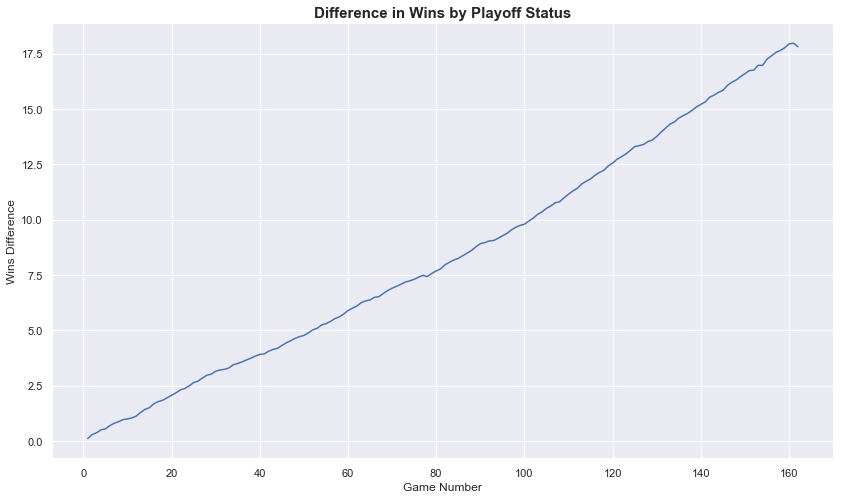

In [25]:
plt.figure(figsize = (14, 8))
sns.lineplot(x = list(range(1, 163)), y = list(difference['wins_difference']))
plt.title('Difference in Wins by Playoff Status', fontsize = 15, fontweight = 'bold')
plt.ylabel('Wins Difference')
plt.xlabel('Game Number')

plt.show()